# Preparing Data
- Using HuggingFace for all models and data
- DistilRoBERTa base is a distilled version of roBERTa, which is a fine-tuned version of BERT, a small LM with about 100-120M parameters used for NLP tasks
- go_emotions_augmented is my own personal dataset of an augmented version of Google's GoEmotions database, where multi-label classification of emotions was performed on Reddit posts.
    - Augmentation: Identified emotional labels that appeared under 1.5% of the time throughout the entire dataset, then used gemma3:4b to create a similar sentence of the same emotional label to add into the dataset

In [1]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from datasets import load_dataset
from utils_emotiontraining import *

model = TFAutoModel.from_pretrained("distilroberta-base")
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
emotion_dataset = load_dataset("jellyshroom/go_emotions_augmented")

small_train_dataset = emotion_dataset['train'].select(range(20000))
small_test_dataset = emotion_dataset['test'].select(range(1000))
small_validation_dataset = emotion_dataset['validation'].select(range(1000))

small_emotion_dataset = {
    'train': small_train_dataset,
    'test': small_test_dataset,
    'validation': small_validation_dataset
}


Device set to use mps
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [3]:
emotions_id2label = {
    0: 'admiration',
    1: 'amusement',
    2: 'anger',
    3: 'annoyance',
    4: 'approval',
    5: 'caring',
    6: 'confusion',
    7: 'curiosity',
    8: 'desire',
    9: 'disappointment',
    10: 'disapproval',
    11: 'disgust',
    12: 'embarrassment',
    13: 'excitement',
    14: 'fear',
    15: 'gratitude',
    16: 'grief',
    17: 'joy',
    18: 'love',
    19: 'nervousness',
    20: 'optimism',
    21: 'pride',
    22: 'realization',
    23: 'relief',
    24: 'remorse',
    25: 'sadness',
    26: 'surprise',
    27: 'neutral'
}

emotions_label2id = {v: k for k, v in emotions_id2label.items()}

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, return_tensors='tf')

# need to tokenize each split
small_emotions_encoded = {}
small_emotions_encoded['train'] = small_emotion_dataset['train'].map(tokenize, batched=True, batch_size=None)
small_emotions_encoded['test'] = small_emotion_dataset['test'].map(tokenize, batched=True, batch_size=None)
small_emotions_encoded['validation'] = small_emotion_dataset['validation'].map(tokenize, batched=True, batch_size=None)

print(small_emotions_encoded['train'])

Dataset({
    features: ['text', 'labels', 'id', 'input_ids', 'attention_mask'],
    num_rows: 20000
})


## Cleaning the column names to prepare for multi-label classification
Because multiple emotions can be expressed within each text, we need to set manage the labels so that each emotion can be classified. We will create a vector with the length of 28, then set each label to the position of 1. Therefore, multiple positions can be 1.

In [ ]:
import numpy as np
import tensorflow as tf
from collections import Counter

NUM_CLASSES = 28

def create_multi_hot_labels(example):
    multi_hot_label = np.zeros(NUM_CLASSES, dtype=np.float32)
    if 'labels' in example and isinstance(example['labels'], list) and len(example['labels']) > 0:
        for label_id in example['labels']:
            if isinstance(label_id, int) and 0 <= label_id < NUM_CLASSES:
                multi_hot_label[label_id] = 1.0
    example['multi_hot_labels'] = multi_hot_label
    return example

# need to apply conversion to add new label column
small_emotions_encoded['train'] = small_emotions_encoded['train'].map(create_multi_hot_labels)
small_emotions_encoded['test'] = small_emotions_encoded['test'].map(create_multi_hot_labels)
small_emotions_encoded['validation'] = small_emotions_encoded['validation'].map(create_multi_hot_labels)

columns_to_remove = [col for col in ['label_int', 'labels'] if col in small_emotions_encoded['train'].features]
if columns_to_remove:
    # print(f"Removing: {columns_to_remove}")
    small_emotions_encoded['train'] = small_emotions_encoded['train'].remove_columns(columns_to_remove)
    small_emotions_encoded['test'] = small_emotions_encoded['test'].remove_columns(columns_to_remove)
    small_emotions_encoded['validation'] = small_emotions_encoded['validation'].remove_columns(columns_to_remove)

# rename to labels
small_emotions_encoded['train'] = small_emotions_encoded['train'].rename_column('multi_hot_labels', 'labels')
small_emotions_encoded['test'] = small_emotions_encoded['test'].rename_column('multi_hot_labels', 'labels')
small_emotions_encoded['validation'] = small_emotions_encoded['validation'].rename_column('multi_hot_labels', 'labels')


Removing existing columns: ['labels']
Renaming 'multi_hot_labels' to 'labels'


## Assigning weights
- Weights are assigned based off of the rarity of the emotion present in the dataset

In [23]:
train_labels_np = np.array(small_emotions_encoded['train']['labels'])
# frequency?
label_counts = np.sum(train_labels_np, axis=0)
total_samples = len(train_labels_np)

# the more rare the emotion, the higher weight
class_weights_calc = {}
for i in range(NUM_CLASSES):
    count = label_counts[i] if label_counts[i] > 0 else 1
    class_weights_calc[i] = total_samples / (NUM_CLASSES * count)

# for multiple emotions detected in a text, weight = most rare one
sample_weights_np = np.zeros(total_samples, dtype=np.float32)
for i in range(total_samples):
    sample_label_indices = np.where(train_labels_np[i] == 1.0)[0]
    if len(sample_label_indices) > 0:
        sample_weights_np[i] = max(class_weights_calc[idx] for idx in sample_label_indices)
    else:
        sample_weights_np[i] = 1.0
print("Sample weights calculated.")


# Set format to tensorflow
feature_cols = ["input_ids", "attention_mask"]
label_col = "labels"
cols_to_set_format = feature_cols + [label_col]

train_features_np = {col: np.array(small_emotions_encoded['train'][col]) for col in feature_cols}
train_labels_np = np.array(small_emotions_encoded['train']['labels'])

test_features_np = {col: np.array(small_emotions_encoded['test'][col]) for col in feature_cols}
test_labels_np = np.array(small_emotions_encoded['test']['labels'])

validation_features_np = {col: np.array(small_emotions_encoded['validation'][col]) for col in feature_cols}
validation_labels_np = np.array(small_emotions_encoded['validation']['labels'])
print("Features and labels extracted as numpy arrays.")

Sample weights calculated.
Features and labels extracted as numpy arrays.


In [24]:

# TensorFlow datasets
BATCH_SIZE = 32

# yield (features, labels, sample_weights)
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_features_np, train_labels_np, sample_weights_np)
)
train_dataset = train_dataset.shuffle(len(sample_weights_np)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# (features, labels)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_features_np, test_labels_np)
)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (validation_features_np, validation_labels_np)
)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


print("Datasets created successfully.")


Datasets created successfully.


## Create class for roberta to load in finetuned model

In [8]:
class BERTForClassification(tf.keras.Model):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.num_classes = num_classes
        self.fc = tf.keras.layers.Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        # input may be a dict
        outputs = self.bert(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            return_dict=True
        )
        pooled_output = outputs.pooler_output
        return self.fc(pooled_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes
        })
        return config

In [9]:
try:
    NUM_CLASSES
except NameError:
    NUM_CLASSES = 28

def predict_emotion(text, model, threshold=0.5):
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
    predictions = model(inputs) # (1, NUM_CLASSES)

    print(f"Raw probabilities for '{text}': {predictions[0].numpy()}")

    predicted_labels_indices = tf.where(predictions[0] > threshold).numpy().flatten()
    predicted_emotions = []
    confidences = []
    if len(predicted_labels_indices) > 0:
        for index in predicted_labels_indices:
            predicted_emotions.append(emotions_id2label[index])
            confidences.append(float(predictions[0][index]))
    else:
        highest_prob_index = tf.argmax(predictions, axis=1).numpy()[0]
        predicted_emotions.append(emotions_id2label[highest_prob_index])
        confidences.append(float(predictions[0][highest_prob_index]))


    return {
        'text': text,
        'emotions': predicted_emotions,
        'confidences': confidences
    }

## Untrained Model Predictions

In [21]:
from utils_emotiontraining import TEST_TEXTS
untrained_classifier = BERTForClassification(model, num_classes=NUM_CLASSES)

untrained_classifier.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

print("Predictions with UNTRAINED model:")
print("-------------------------------------------------------------")

for text in TEST_TEXTS:
    result = predict_emotion(text, untrained_classifier, threshold=0.5)
    print(f"Text: {result['text']}")
    print(f"Predicted emotions: {result['emotions']}")
    emotion_confidence_pairs = list(zip(result['emotions'], result['confidences']))
    print(f"Confidences: {emotion_confidence_pairs}")
    print()

Predictions with UNTRAINED model (random weights - multi-label):
-------------------------------------------------------------
Raw probabilities for 'I'm so happy today!': [0.3647775  0.46604145 0.71257216 0.6748999  0.5231001  0.4923539
 0.81130844 0.22087218 0.33193052 0.32434133 0.2523739  0.36111632
 0.5680941  0.57176626 0.3669782  0.4474013  0.27805743 0.5727703
 0.90865403 0.24848849 0.74004817 0.5476425  0.59768933 0.4063118
 0.29717106 0.529662   0.4651278  0.23796488]
Text: I'm so happy today!
Predicted emotions: ['anger', 'annoyance', 'approval', 'confusion', 'embarrassment', 'excitement', 'joy', 'love', 'optimism', 'pride', 'realization', 'sadness']
Confidences: [('anger', 0.7125721573829651), ('annoyance', 0.6748998761177063), ('approval', 0.5231000781059265), ('confusion', 0.8113084435462952), ('embarrassment', 0.5680940747261047), ('excitement', 0.5717662572860718), ('joy', 0.5727702975273132), ('love', 0.9086540341377258), ('optimism', 0.7400481700897217), ('pride', 0.5

## Training RoBERTa model

In [10]:

try:
    NUM_CLASSES
except NameError:
    NUM_CLASSES = 28

classifier = BERTForClassification(model, num_classes=NUM_CLASSES)

print("Compiling model with AUC, Precision, Recall...")
classifier.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(multi_label=True, name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
        ]
)
print("Model compiled.")

Compiling model with AUC, Precision, Recall...
Model compiled.


In [23]:

print("Starting multi-label model training...")
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_emotion_model.keras', save_best_only=True, monitor='val_auc', mode='max')
]

history = classifier.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks
)
print("Training finished.")

print("Evaluating model on test set...")
results = classifier.evaluate(test_dataset, verbose=1)

print("\nTest Set Evaluation Results:")
for name, value in zip(classifier.metrics_names, results):
    print(f"- {name}: {value:.4f}")

# test_loss = results[classifier.metrics_names.index('loss')]
# test_auc = results[classifier.metrics_names.index('auc')]
# print(f"\nTest Loss: {test_loss:.4f}")
# print(f"Test AUC: {test_auc:.4f}")

Starting multi-label model training with sample weights...
Epoch 1/5
625/625 [==============================] - 3146s 5s/step - loss: 0.1398 - accuracy: 0.9568 - auc: 0.8232 - precision: 0.4528 - recall: 0.1283 - val_loss: 0.1168 - val_accuracy: 0.9632 - val_auc: 0.8921 - val_precision: 0.6888 - val_recall: 0.2659
Epoch 2/5
625/625 [==============================] - 3169s 5s/step - loss: 0.0976 - accuracy: 0.9636 - auc: 0.9131 - precision: 0.6691 - recall: 0.2684 - val_loss: 0.1080 - val_accuracy: 0.9622 - val_auc: 0.8998 - val_precision: 0.6287 - val_recall: 0.3016
Epoch 3/5
625/625 [==============================] - 3159s 5s/step - loss: 0.0844 - accuracy: 0.9646 - auc: 0.9334 - precision: 0.6525 - recall: 0.3392 - val_loss: 0.1055 - val_accuracy: 0.9620 - val_auc: 0.9078 - val_precision: 0.6059 - val_recall: 0.3389
Epoch 4/5
625/625 [==============================] - 3036s 5s/step - loss: 0.0754 - accuracy: 0.9657 - auc: 0.9463 - precision: 0.6532 - recall: 0.3946 - val_loss: 0.1052

In [25]:
print("Predictions with TRAINED multi-label model:")
print("----------------------------------------")

prediction_threshold = 0.2

test_texts = TEST_TEXTS

print("Loading best model weights from checkpoint...")
classifier.load_weights('best_emotion_model.keras')

for text in test_texts:
    result = predict_emotion(text, classifier, threshold=prediction_threshold)
    print(f"Text: {result['text']}")
    print(f"Predicted emotions: {result['emotions']}")
    emotion_confidence_pairs = list(zip(result['emotions'], result['confidences']))
    print(f"Confidences: {emotion_confidence_pairs}")
    # print(f"Confidences: {[f'{c:.4f}' for c in result['confidences']]}")
    print()

Predictions with TRAINED multi-label model:
----------------------------------------
Loading best model weights from checkpoint...
Raw probabilities for 'I'm so happy today!': [3.5804652e-02 6.7219036e-03 3.5327272e-03 4.2225751e-03 2.2938062e-02
 2.1542782e-02 1.8839212e-03 4.4516129e-03 4.6389336e-03 2.3737701e-03
 9.3714846e-04 1.1744318e-03 3.6886306e-03 8.9674823e-02 2.7164354e-03
 2.1942558e-02 8.9404261e-04 9.5895094e-01 3.8458385e-02 2.9750334e-03
 8.6716171e-03 3.1830974e-02 1.1759102e-02 7.2076959e-03 3.7947532e-03
 1.0251633e-02 2.5655765e-03 6.0006138e-03]
Text: I'm so happy today!
Predicted emotions: ['joy']
Confidences: [('joy', 0.958950936794281)]

Raw probabilities for 'This makes me really angry.': [0.0045552  0.01158904 0.9307607  0.18818492 0.00901619 0.00386939
 0.00210112 0.00174721 0.00395207 0.01632867 0.0182901  0.07202452
 0.0048206  0.00815627 0.0109376  0.01113673 0.0043633  0.00679844
 0.00830816 0.00545055 0.00529313 0.02591576 0.00787402 0.01033634
 0.0160

## Model Evaulation Debugging (ignore this section)

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel

print("Attempting to load best model from .keras file and save weights to .h5...")

keras_model_path = 'best_emotion_model.keras' 
h5_weights_path = 'best_emotion_model_weights.h5'
base_model_name = "distilroberta-base"

try:
    num_classes = NUM_CLASSES
except NameError:
    num_classes = 28

try:
    print(f"Loading base model: {base_model_name}")
    base_model_reload = TFAutoModel.from_pretrained(base_model_name)

    print("Instantiating classifier structure...")
    classifier_reload = BERTForClassification(base_model_reload, num_classes=num_classes)

    print("Building model...")
    dummy_seq_len = 10
    dummy_input_ids = tf.zeros([1, dummy_seq_len], dtype=tf.int32)
    dummy_attention_mask = tf.zeros([1, dummy_seq_len], dtype=tf.int32)
    dummy_inputs = {'input_ids': dummy_input_ids, 'attention_mask': dummy_attention_mask}
    _ = classifier_reload(dummy_inputs) # Build step

    print(f"Loading weights from: {keras_model_path}")
    classifier_reload.load_weights(keras_model_path)
    print("Weights loaded successfully from .keras file.")

    print(f"Saving weights to: {h5_weights_path}")
    classifier_reload.save_weights(h5_weights_path)

    print(f"Weights successfully extracted and saved to: {h5_weights_path}")

except FileNotFoundError:
     print(f"ERROR: Could not find the saved model file: {keras_model_path}")
     print("Please ensure the training cell ran successfully and saved the checkpoint.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Ensure the BERTForClassification class is defined correctly and necessary variables (like NUM_CLASSES) are set.")


Attempting to load best model from .keras file and save weights to .h5...
Loading base model: distilroberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Instantiating classifier structure...
Building model...
Loading weights from: best_emotion_model.keras


/Users/kihyvr/miniconda3/envs/llmenv/lib/python3.9/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Weights loaded successfully from .keras file.
Saving weights to: best_emotion_model_weights.h5
Weights successfully extracted and saved to: best_emotion_model_weights.h5


In [12]:
#save as h5 to try and get it working
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
import numpy as np
import os
from utils_emotiontraining import *

test_texts = TEST_TEXTS


keras_model_path = 'best_emotion_model.keras'
h5_weights_path = 'best_emotion_model_weights.h5'
base_model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

def load_and_build_classifier(num_classes):
    print(f"Loading base model: {base_model_name}")
    base_model_instance = TFAutoModel.from_pretrained(base_model_name)
    print("Instantiating classifier structure...")
    classifier_instance = BERTForClassification(base_model_instance, num_classes=num_classes)
    print("Building model...")
    dummy_seq_len = 10
    dummy_input_ids = tf.zeros([1, dummy_seq_len], dtype=tf.int32)
    dummy_attention_mask = tf.zeros([1, dummy_seq_len], dtype=tf.int32)
    dummy_inputs = {'input_ids': dummy_input_ids, 'attention_mask': dummy_attention_mask}
    _ = classifier_instance(dummy_inputs) # build step
    return classifier_instance


try:
    num_classes_check = NUM_CLASSES
except NameError:
    print("Warning: NUM_CLASSES not found, using default 28.")
    num_classes_check = 28

model_from_keras = None
model_from_h5 = None

#load from keras
if os.path.exists(keras_model_path):
    print(f"\nLoading model from {keras_model_path}...")
    try:
        model_from_keras = load_and_build_classifier(num_classes_check)
        model_from_keras.load_weights(keras_model_path)
        print(f"Successfully loaded weights from {keras_model_path}")
    except Exception as e:
        print(f"ERROR loading from {keras_model_path}: {e}")
else:
    print(f"SKIPPING .keras test: File not found at {keras_model_path}")

# load from h5
if os.path.exists(h5_weights_path):
    print(f"\nLoading model from {h5_weights_path}...")
    try:
        model_from_h5 = load_and_build_classifier(num_classes_check)
        model_from_h5.load_weights(h5_weights_path)
        print(f"Successfully loaded weights from {h5_weights_path}")
    except Exception as e:
        print(f"ERROR loading from {h5_weights_path}: {e}")
else:
    print(f"SKIPPING .h5 test: File not found at {h5_weights_path}")


# run predictions for comparison
if model_from_keras and model_from_h5:
    print("\n--- Comparing Predictions (should be identical) ---")
    try:
        texts_to_predict = test_texts
    except NameError:
        print("ERROR: test_texts list not defined. Cannot run predictions.")
        texts_to_predict = []

    comparison_threshold = 0.5

    for text in texts_to_predict:
        print(f"\nText: {text}")

        print("  Predicting with model from .keras file:")
        result_keras = predict_emotion(text, model_from_keras, threshold=comparison_threshold)
        print(f"    Predicted (.keras): {result_keras['emotions']} ({[f'{c:.4f}' for c in result_keras['confidences']]})")

        print("  Predicting with model from .h5 file:")
        result_h5 = predict_emotion(text, model_from_h5, threshold=comparison_threshold)
        print(f"    Predicted (.h5):   {result_h5['emotions']} ({[f'{c:.4f}' for c in result_h5['confidences']]})")

        if result_keras['emotions'] == result_h5['emotions'] and np.allclose(result_keras['confidences'], result_h5['confidences'], atol=1e-6):
             print("    >> Predictions Match!")
        else:
             print("    >> WARNING: Predictions differ!")

elif not model_from_keras and not model_from_h5:
    print("\nCould not load model from either .keras or .h5 file. Cannot run comparison.")
else:
    print("\nCould only load model from one file type. Cannot run comparison.")


--- Testing Loaded Models ---

Loading model from best_emotion_model.keras...
Loading base model: distilroberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Instantiating classifier structure...
Building model...
Successfully loaded weights from best_emotion_model.keras

Loading model from best_emotion_model_weights.h5...
Loading base model: distilroberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Instantiating classifier structure...
Building model...
Successfully loaded weights from best_emotion_model_weights.h5

--- Comparing Predictions (should be identical) ---

Text: I'm so happy today!
  Predicting with model from .keras file:
Raw probabilities for 'I'm so happy today!': [3.5804652e-02 6.7219036e-03 3.5327272e-03 4.2225751e-03 2.2938062e-02
 2.1542782e-02 1.8839212e-03 4.4516129e-03 4.6389336e-03 2.3737701e-03
 9.3714846e-04 1.1744318e-03 3.6886306e-03 8.9674823e-02 2.7164354e-03
 2.1942558e-02 8.9404261e-04 9.5895094e-01 3.8458385e-02 2.9750334e-03
 8.6716171e-03 3.1830974e-02 1.1759102e-02 7.2076959e-03 3.7947532e-03
 1.0251633e-02 2.5655765e-03 6.0006138e-03]
    Predicted (.keras): ['joy'] (['0.9590'])
  Predicting with model from .h5 file:
Raw probabilities for 'I'm so happy today!': [3.5804652e-02 6.7219036e-03 3.5327272e-03 4.2225751e-03 2.2938062e-02
 2.1542782e-02 1.8839212e-03 4.4516129e-03 4.6389336e-03 2.3737701e-03
 9.3714846e-04 1.1744318e-03 3.6886306e-03 8

# Evaluation

In [25]:
import joblib
import os
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

SKLEARN_MODEL_DIR = "../training/"
MNB_MODEL_LOAD_PATH = os.path.join(SKLEARN_MODEL_DIR, "trained_mnb_model.joblib")
LR_MODEL_LOAD_PATH = os.path.join(SKLEARN_MODEL_DIR, "trained_lr_model.joblib")
VECTORIZER_LOAD_PATH = os.path.join(SKLEARN_MODEL_DIR, "tfidf_vectorizer.joblib")
MLB_LOAD_PATH = os.path.join(SKLEARN_MODEL_DIR, "mlb_binarizer.joblib")

try:
    NUM_CLASSES
    emotions_id2label
except NameError:
    NUM_CLASSES = 28
    emotions_id2label = { 0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}

PLOT_SAVE_DIR = "plots"
if not os.path.exists(PLOT_SAVE_DIR):
    os.makedirs(PLOT_SAVE_DIR)
    print(f"Created plot directory: {PLOT_SAVE_DIR}")
    
print("Loading scikit-learn components...")
try:
    vectorizer_loaded = joblib.load(VECTORIZER_LOAD_PATH)
    mlb_loaded = joblib.load(MLB_LOAD_PATH)
    mnb_model_loaded = joblib.load(MNB_MODEL_LOAD_PATH)
    lr_model_loaded = joblib.load(LR_MODEL_LOAD_PATH)
    print("Successfully loaded vectorizer, MLB, MNB, and LR models.")
    sklearn_components_loaded = True
except FileNotFoundError as e:
    print(f"ERROR loading file: {e}")
    sklearn_components_loaded = False
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    sklearn_components_loaded = False

Loading scikit-learn components...
Successfully loaded vectorizer, MLB, MNB, and LR models.


In [27]:
try:
    test_texts_raw = [item['text'] for item in small_test_dataset]

    if test_labels_np.shape[0] != len(test_texts_raw) or test_labels_np.shape[1] != NUM_CLASSES:
         raise ValueError("Mismatch between number of test texts and ground truth labels shape.")

    if sklearn_components_loaded:
        test_texts_tfidf = vectorizer_loaded.transform(test_texts_raw)

    data_prepared = True

except NameError as e:
    print(f"ERROR: Required variable not found: {e}")
    data_prepared = False
except Exception as e:
    print(f"An error occurred during data preparation: {e}")
    data_prepared = False

## Load weights explicitly into a newly instantiated roberta model for evaluation

In [18]:
y_pred_proba_bert = None
y_pred_proba_mnb = None
y_pred_proba_lr = None

BERT_WEIGHTS_PATH = "best_emotion_model.keras"


try:
    if os.path.exists(h5_weights_path):
        print(f"\nLoading model from {h5_weights_path}...")
        try:
            model_from_h5 = load_and_build_classifier(num_classes_check)
            model_from_h5.load_weights(h5_weights_path)
            print(f"Successfully loaded weights from {h5_weights_path}")
        except NameError as e:
            print(f"ERROR: Required variable not found: {e}")
            data_prepared = False
    print('BERT weights loaded successfully into classifier variable.')
except Exception as load_err:
    print(f'!!! ERROR loading weights into classifier: {load_err} !!!')
    print('!!! WARNING: Proceeding with potentially untrained BERT classifier. !!!')
    pass
y_pred_proba_bert = model_from_h5.predict(test_dataset)
print(f"BERT predictions shape: {y_pred_proba_bert.shape}")

if sklearn_components_loaded:
    y_pred_proba_mnb = mnb_model_loaded.predict_proba(test_texts_tfidf)
    print(f"MNB predictions shape: {y_pred_proba_mnb.shape}")

    y_pred_proba_lr = lr_model_loaded.predict_proba(test_texts_tfidf)
    print(f"LR predictions shape: {y_pred_proba_lr.shape}")

predictions_obtained = True



Attempting to load BERT weights from: best_emotion_model.keras

Loading model from best_emotion_model_weights.h5...
Loading base model: distilroberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Instantiating classifier structure...
Building model...
Successfully loaded weights from best_emotion_model_weights.h5
BERT weights loaded successfully into classifier variable.
Getting predictions from BERT model (model_from_h5)...
32/32 [==============================] - 12s 353ms/step
BERT predictions shape: (1000, 28)
Getting predictions from MultinomialNB model...
MNB predictions shape: (1000, 28)
Getting predictions from LogisticRegression model...
LR predictions shape: (1000, 28)


In [19]:
def evaluate_model_performance_notebook(y_true, y_pred_proba, model_name_for_print):
    print(f"\n--- Evaluating: {model_name_for_print} ---")
    if y_pred_proba is None:
        print("  No predictions available to evaluate.")
        return None
    if y_true is None:
        print("  Ground truth labels not available.")
        return None
    if y_true.shape[0] != y_pred_proba.shape[0] or y_true.shape[1] != y_pred_proba.shape[1]:
         print(f"  ERROR: Shape mismatch! y_true: {y_true.shape}, y_pred_proba: {y_pred_proba.shape}")
         return None

    # 0.2 threshold
    y_pred_bin = (y_pred_proba > 0.2).astype(int)

    accuracy = accuracy_score(y_true, y_pred_bin)
    precision_micro = precision_score(y_true, y_pred_bin, average='micro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred_bin, average='micro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred_bin, average='micro', zero_division=0)

    precision_macro = precision_score(y_true, y_pred_bin, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred_bin, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred_bin, average='macro', zero_division=0)

    try:
        roc_auc_micro = roc_auc_score(y_true, y_pred_proba, average='micro', multi_class='ovr')
        roc_auc_macro = roc_auc_score(y_true, y_pred_proba, average='macro', multi_class='ovr')
    except ValueError as e:
         print(f"  ROC AUC calculation error (possibly due to all-zero column?): {e}")
         roc_auc_micro = np.nan
         roc_auc_macro = np.nan


    print(f"  Accuracy (Exact Match): {accuracy:.4f}")
    print(f"  Precision (Micro):      {precision_micro:.4f}")
    print(f"  Recall (Micro):         {recall_micro:.4f}")
    print(f"  F1-Score (Micro):       {f1_micro:.4f}")
    print(f"  Precision (Macro):      {precision_macro:.4f}")
    print(f"  Recall (Macro):         {recall_macro:.4f}")
    print(f"  F1-Score (Macro):       {f1_macro:.4f}")
    print(f"  ROC AUC (Micro):        {roc_auc_micro:.4f}")
    print(f"  ROC AUC (Macro):        {roc_auc_macro:.4f}")

    metrics = {
        'accuracy': accuracy,
        'precision_micro': precision_micro, 'recall_micro': recall_micro, 'f1_micro': f1_micro,
        'precision_macro': precision_macro, 'recall_macro': recall_macro, 'f1_macro': f1_macro,
        'roc_auc_micro': roc_auc_micro, 'roc_auc_macro': roc_auc_macro
    }
    return metrics

In [ ]:
if data_prepared and predictions_obtained:
    print("\n" + "="*20 + " MODEL EVALUATION RESULTS " + "="*20)
    metrics_bert = evaluate_model_performance_notebook(test_labels_np, y_pred_proba_bert, "BERT")
    if sklearn_components_loaded:
        metrics_mnb = evaluate_model_performance_notebook(test_labels_np, y_pred_proba_mnb, "MultinomialNB")
        metrics_lr = evaluate_model_performance_notebook(test_labels_np, y_pred_proba_lr, "LogisticRegression")
    print("="*62)


==================== MODEL EVALUATION RESULTS ====================

--- Evaluating: BERT ---
  Accuracy (Exact Match): 0.2350
  Precision (Micro):      0.3990
  Recall (Micro):         0.6387
  F1-Score (Micro):       0.4912
  Precision (Macro):      0.3654
  Recall (Macro):         0.6630
  F1-Score (Macro):       0.4488
  ROC AUC (Micro):        0.9410
  ROC AUC (Macro):        0.9269

--- Evaluating: MultinomialNB ---
  Accuracy (Exact Match): 0.0620
  Precision (Micro):      0.0967
  Recall (Micro):         0.7770
  F1-Score (Micro):       0.1720
  Precision (Macro):      0.0652
  Recall (Macro):         0.5570
  F1-Score (Macro):       0.1127
  ROC AUC (Micro):        0.8247
  ROC AUC (Macro):        0.6985

--- Evaluating: LogisticRegression ---
  Accuracy (Exact Match): 0.0150
  Precision (Micro):      0.1516
  Recall (Micro):         0.8773
  F1-Score (Micro):       0.2585
  Precision (Macro):      0.1530
  Recall (Macro):         0.7535
  F1-Score (Macro):       0.2395
  ROC 

In [21]:
def plot_roc_curves_comparison_notebook(y_true_bin, predictions_proba_map, save_dir=PLOT_SAVE_DIR):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created plot directory: {save_dir}")

    plt.figure(figsize=(14, 11))
    model_colors = {
        "BERT": "blue",
        "MultinomialNB": "green",
        "LogisticRegression": "red",
        "BERT_macro": "darkblue",
        "MultinomialNB_macro": "darkgreen",
        "LogisticRegression_macro": "darkred"
    }
    results_auc = {}

    for model_name, y_pred_proba in predictions_proba_map.items():
        if y_pred_proba is None:
            print(f"Skipping ROC for {model_name} (no predictions).")
            continue
        if not isinstance(y_pred_proba, np.ndarray):
            y_pred_proba = np.array(y_pred_proba)
        if y_true_bin.shape[0] != y_pred_proba.shape[0] or y_true_bin.shape[1] != y_pred_proba.shape[1]:
             print(f"Skipping ROC for {model_name} due to shape mismatch!")
             continue

        results_auc[model_name] = {}

        try:
            fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
            roc_auc_micro = auc(fpr_micro, tpr_micro)
            results_auc[model_name]['micro'] = roc_auc_micro
            plt.plot(
                fpr_micro, tpr_micro,
                label=f'{model_name} Micro-avg ROC (area = {roc_auc_micro:0.3f})',
                color=model_colors.get(model_name, "gray"),
                linestyle='-', linewidth=2
            )
        except Exception as e:
            print(f"Could not calculate Micro ROC for {model_name}: {e}")
            results_auc[model_name]['micro'] = np.nan

        try:
            all_fpr = np.unique(np.concatenate([roc_curve(y_true_bin[:, i], y_pred_proba[:, i])[0] for i in range(NUM_CLASSES) if np.sum(y_true_bin[:, i]) > 0]))
            mean_tpr = np.zeros_like(all_fpr)
            valid_classes_count = 0
            for i in range(NUM_CLASSES):
                if np.sum(y_true_bin[:, i]) > 0 and not np.all(np.isnan(y_pred_proba[:, i])):
                    fpr_class, tpr_class, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
                    mean_tpr += np.interp(all_fpr, fpr_class, tpr_class)
                    valid_classes_count +=1
            if valid_classes_count > 0:
                mean_tpr /= valid_classes_count
                roc_auc_macro = auc(all_fpr, mean_tpr)
                results_auc[model_name]['macro'] = roc_auc_macro
                plt.plot(
                    all_fpr, mean_tpr,
                    label=f'{model_name} Macro-avg ROC (area = {roc_auc_macro:0.3f})',
                    color=model_colors.get(model_name + "_macro", "lightgray"),
                    linestyle=':', linewidth=2
                )
        except Exception as e:
            print(f"Could not calculate Macro ROC for {model_name}: {e}")
            results_auc[model_name]['macro'] = np.nan


    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Comparative ROC Curves (Micro and Macro Averages)")
    plt.legend(loc="lower right", fontsize='medium')
    plt.grid(True)

    plot_filename = os.path.join(save_dir, "roc_curves_comparison_notebook.png")
    plt.savefig(plot_filename)
    print(f"Saved comparative ROC plot to {plot_filename}")
    plt.show()
    plt.close()
    return results_auc


Generating combined ROC curves...
Saved comparative ROC plot to plots/roc_curves_comparison_notebook.png


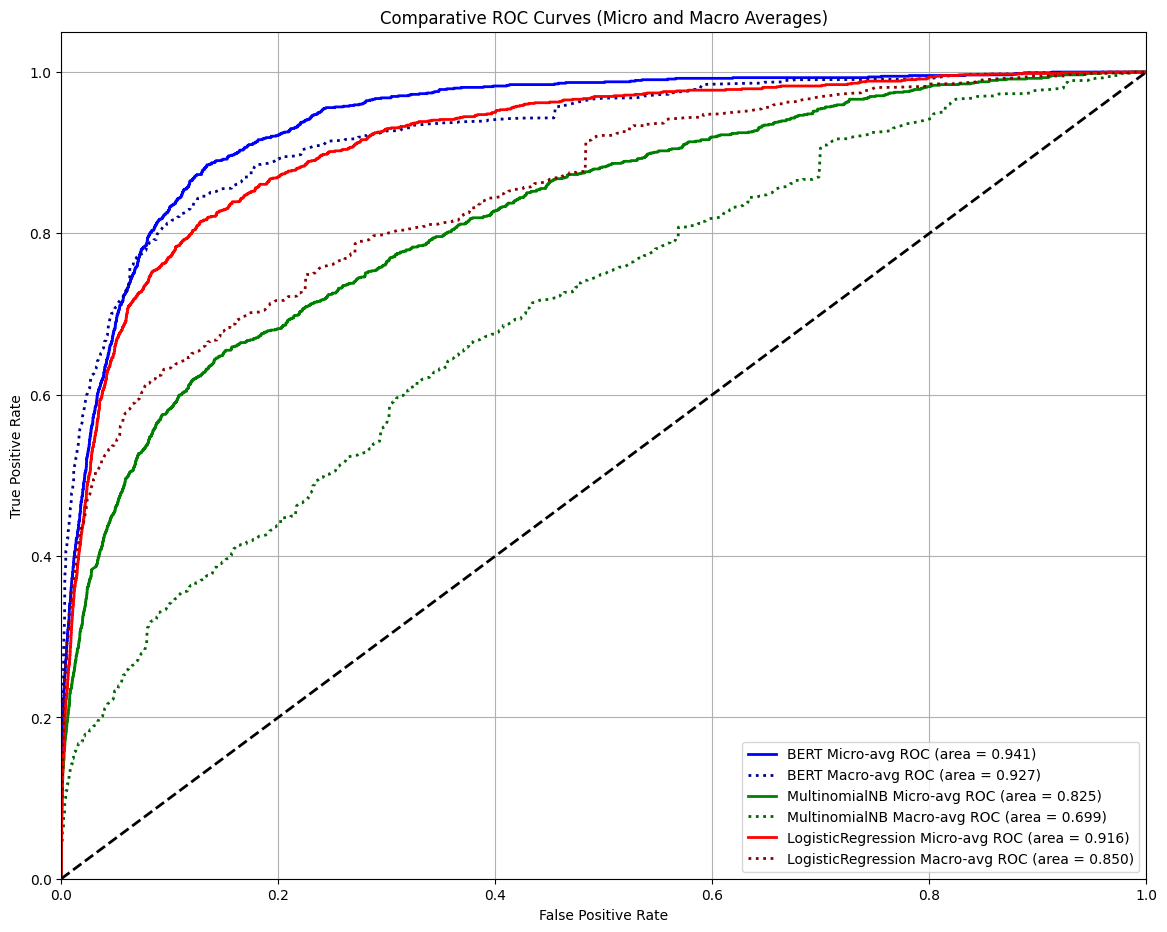


--- Notebook Evaluation Complete ---


In [ ]:
if data_prepared and predictions_obtained:
    predictions_map_notebook = {}
    if y_pred_proba_bert is not None:
        predictions_map_notebook["BERT"] = y_pred_proba_bert
    if sklearn_components_loaded:
        if y_pred_proba_mnb is not None:
             predictions_map_notebook["MultinomialNB"] = y_pred_proba_mnb
        if y_pred_proba_lr is not None:
             predictions_map_notebook["LogisticRegression"] = y_pred_proba_lr

    if predictions_map_notebook:
         plot_roc_curves_comparison_notebook(test_labels_np, predictions_map_notebook)